In [ ]:
from DiffusionModel import DiffusionModel
from configs.base_config import *
from torchvision import transforms
from utils import get_dataloader
from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np
#from diffusers import AutoencoderKL
import matplotlib.pyplot as plt
#from diffusers.optimization import get_cosine_schedule_with_warmup

######## very interesting discussion on VAE
# https://www.reddit.com/r/StableDiffusion/comments/1ag5h5s/the_vae_used_for_stable_diffusion_1x2x_and_other/
####### Very nice example
# https://github.com/FrsECM/diffusers/blob/add-semantic-diffusion/examples/community/semantic_image_synthesis/train_vae_ldm.py
######### also EMA seems to help
######### authors of SDXL say large batch size for training the VAE is important also they seem to favor L1 loss !
##### https://github.com/huggingface/diffusers/pull/7604

In [2]:
print("\n----------INITIALISATION----------\n")

exp="SSH"

# Load config
if exp=="SSH":
    config = SSHTrainingConfig()
if exp=="TOCE":
    config = TOCETrainingConfig()

print("Config loaded")
config.train_batch_size = 8 ####### 8 
train_dataloader = get_dataloader(config.data_file, batch_size=config.train_batch_size, fields=config.fields)
config.data_shape = train_dataloader.get_data_shape()
print("Data loaded")
print(config.data_shape)


----------INITIALISATION----------

Config loaded
Reading infos in /gpfsstore/rech/omr/ufk69pe/dino_1_4_degree.tar
Data loaded
(1, 800, 248)


In [3]:
# very important!!!!! I changed "nearest" to "bilinear" here
# ~/.conda/envs/MLenv/lib/python3.11/site-packages/diffusers/models/upsampling.py 

In [4]:
# Model Initialization

if exp=="SSH":
    model = AutoencoderKL(in_channels = 1,
            out_channels = 1,
            down_block_types = ("DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D",),
            up_block_types = ("UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D",),
            block_out_channels = (64, 64, 64,),
            layers_per_block = 1,
            act_fn = "silu",
            latent_channels= 1,
            scaling_factor = 1.).to('cuda') #### attention au scaling factor, check D1 in https://arxiv.org/pdf/2112.10752
if exp=="TOCE":
    model = AutoencoderKL(in_channels = 18,
            out_channels = 18,
            down_block_types = ("DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D",),
            up_block_types = ("UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D",),
            block_out_channels = (64, 64, 64,),
            layers_per_block = 1,
            act_fn = "silu",
            latent_channels= 4,
            scaling_factor = 1.).to('cuda') #### attention au scaling factor, check D1 in https://arxiv.org/pdf/2112.10752

In [5]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

1153253

In [6]:
epochs = 30
loss_l1 = torch.nn.L1Loss().to('cuda')
loss_mse = torch.nn.MSELoss().to('cuda')

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3) 
lr_scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer,
                                              num_warmup_steps=0,
                                              num_training_steps=225*epochs)

losses = []

In [ ]:
kl_weight = 1e-6

model.train()

for epoch in range(epochs):
    running_loss=0.
    print(epoch)
    for image in train_dataloader:
        image = image.to('cuda')
        posterior = model.encode(image).latent_dist
        reconstructed = model.decode(posterior.sample()).sample
        #############
        loss_rec = loss_l1(reconstructed,image)
        loss_kl = posterior.kl().mean()
        loss = loss_rec + kl_weight * loss_kl
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        print(loss_rec.item(), loss_kl.item())
        #print(loss.item())
        running_loss += loss.item()
    losses.append(running_loss)

#L1: 0.01 0.004 8400

0
0.5502928495407104 3563.3671875
0.4956634044647217 10050.224609375
0.39133962988853455 18188.59765625
0.35637885332107544 23442.97265625
0.29591336846351624 20036.865234375
0.2651098072528839 13323.7998046875
0.18864911794662476 9217.431640625
0.13174596428871155 6677.2060546875
0.18084624409675598 7297.0283203125
0.14282087981700897 9964.30078125
0.11549960821866989 12471.373046875
0.08966946601867676 14090.345703125
0.09852155297994614 15146.779296875
0.08534999191761017 15989.84765625
0.08898238837718964 16485.58203125
0.09098432213068008 16851.2578125
0.06727853417396545 17008.8984375
0.07387597113847733 16878.69921875
0.08172550052404404 16359.8662109375
0.07318712770938873 15505.044921875
0.07702355831861496 14385.349609375
0.07064737379550934 13246.11328125
0.06527948379516602 12153.267578125
0.07200337946414948 11384.4462890625
0.0757158100605011 10969.0048828125
0.0693366602063179 10746.833984375
0.07085961848497391 10838.001953125
0.07025456428527832 10993.041015625
0.06477

In [ ]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.semilogy(losses)

# Saving

In [15]:
if exp=="SSH":
    model.from_pretrained('./backbones/AutoEncoder/SSH/')
    #model.save_pretrained('./backbones/AutoEncoder/SSH/')
if exp=="TOCE":
    #model.from_pretrained('./backbones/AutoEncoder/TOCE/')
    model.save_pretrained('./backbones/AutoEncoder/TOCE/')

# Test

In [10]:
model.eval()

with torch.no_grad():
    test_image = next(iter(train_dataloader))
    test_image.shape
    reconstructed = model(test_image.to("cuda"))

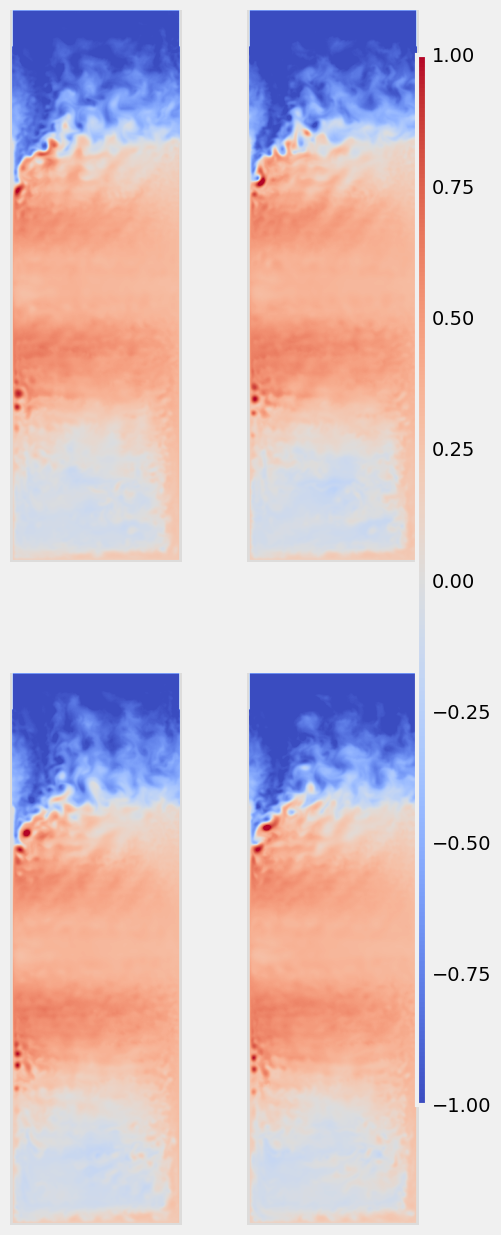

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(5, 15))

for i in range(4):
    ax = axs[i // 2, i % 2]
    cax = ax.imshow(test_image[i, 0].detach().cpu(), cmap='coolwarm', vmin=-1, vmax=1)
    ax.axis('off')  # Hide the axis

# Create an axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position and size of colorbar

# Use the last image to set the colorbar with limits
fig.colorbar(cax, cax=cbar_ax)

#plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.show()

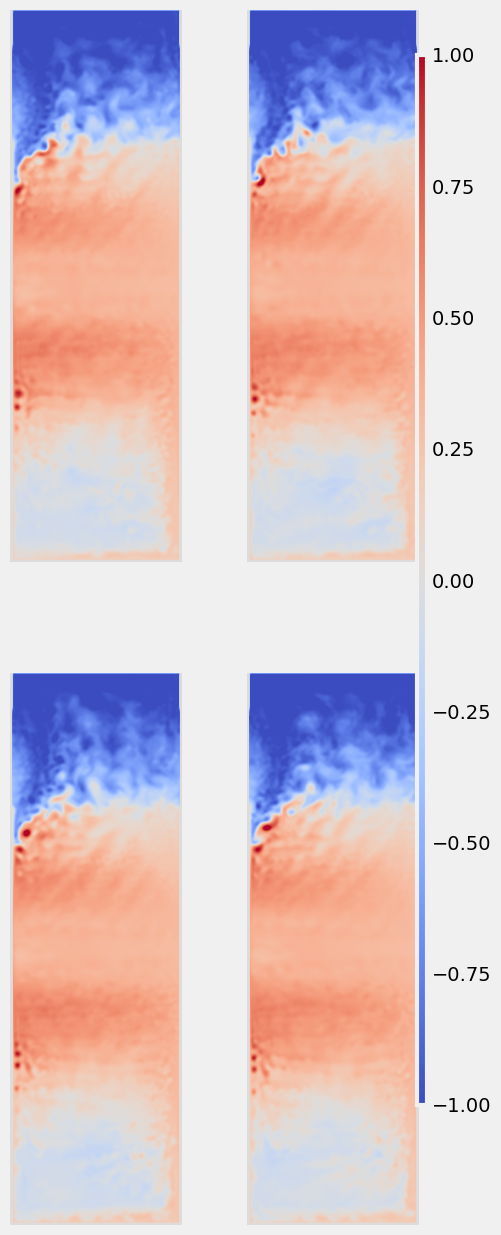

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(5, 15))

for i in range(4):
    ax = axs[i // 2, i % 2]
    cax = ax.imshow(reconstructed.sample[i, 0].detach().cpu(), cmap='coolwarm', vmin=-1, vmax=1)
    ax.axis('off')  # Hide the axis

# Create an axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position and size of colorbar

# Use the last image to set the colorbar with limits
fig.colorbar(cax, cax=cbar_ax)

#plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.show()

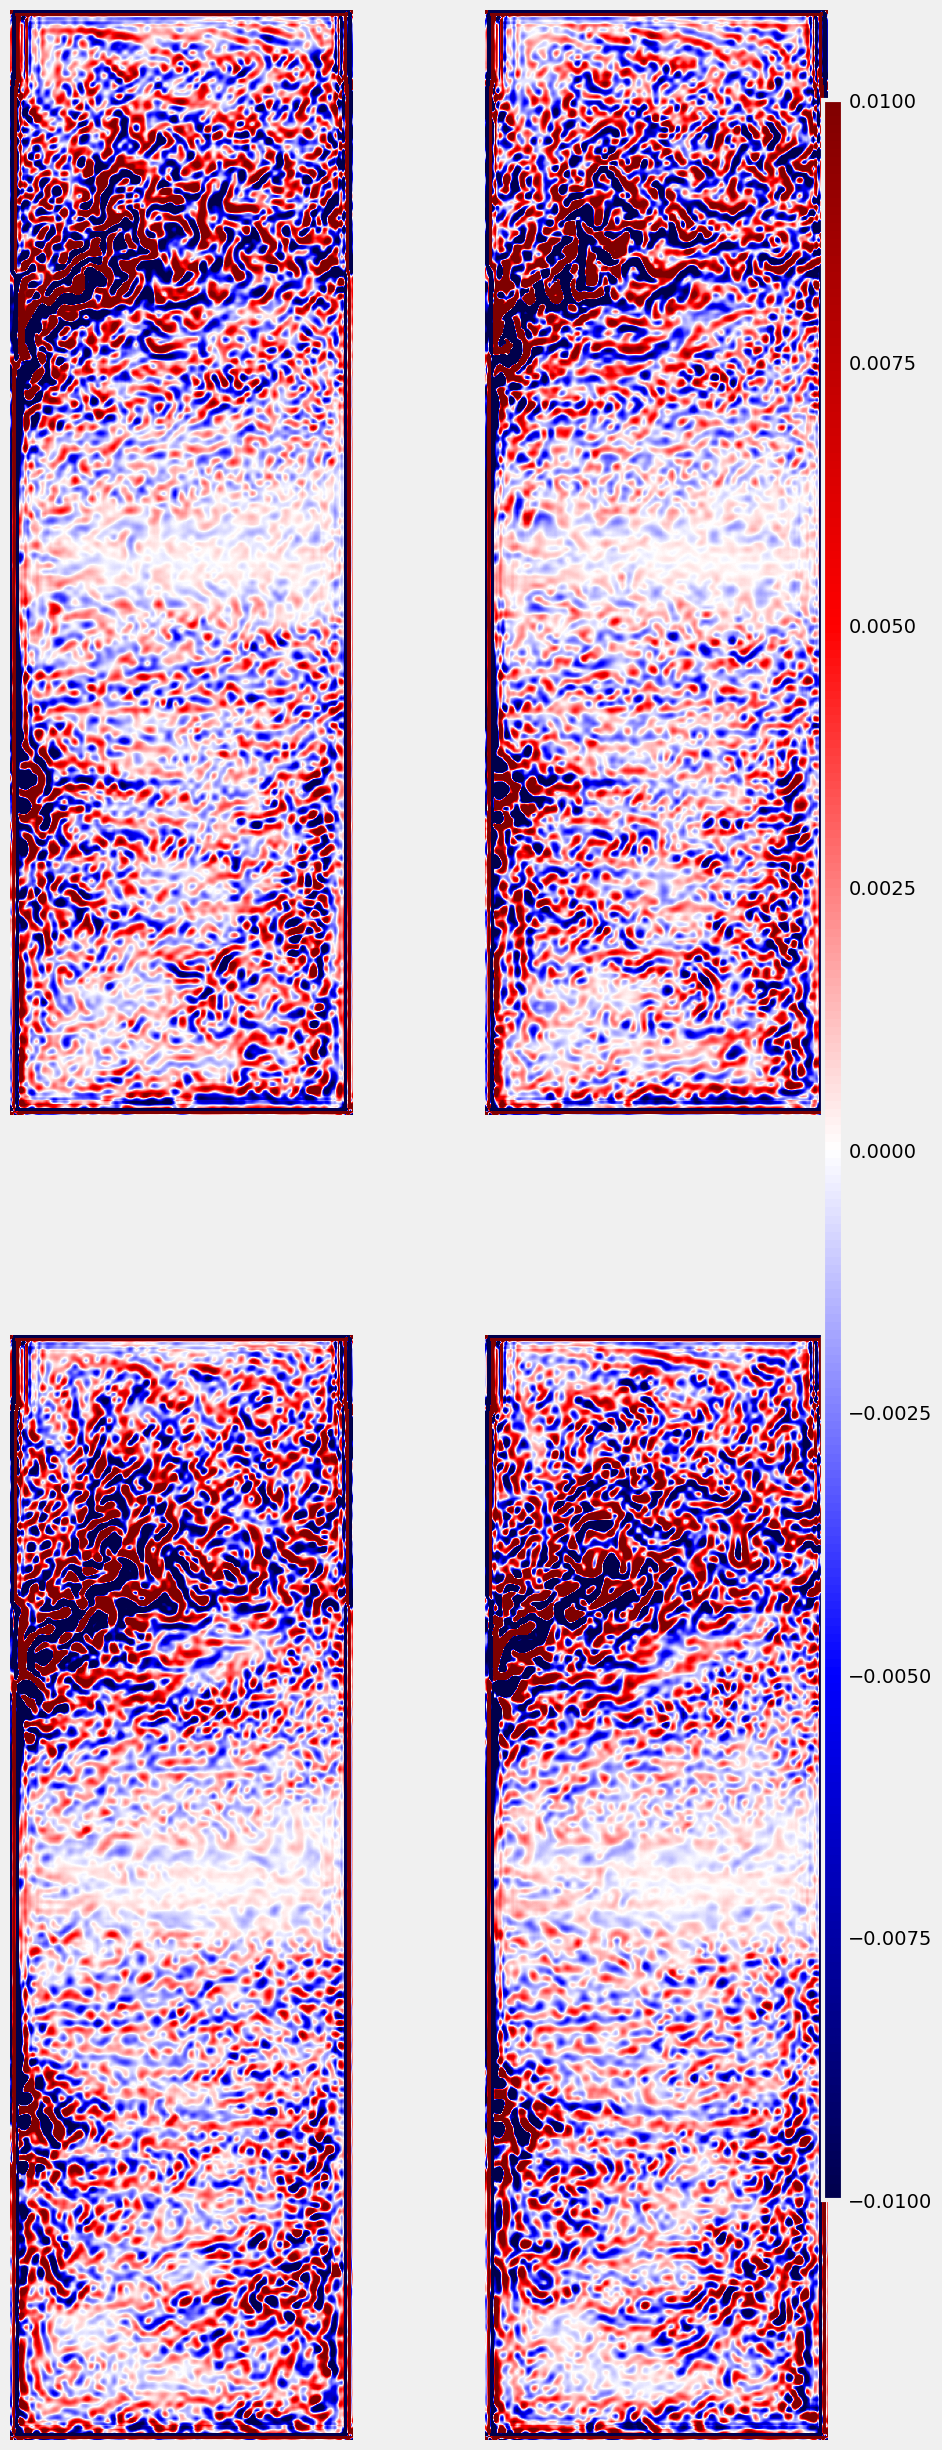

In [13]:
def compute_laplacian(image):
    # Compute gradients along x and y axis
    grad_x = np.gradient(image, axis=0)
    grad_y = np.gradient(image, axis=1)
    
    # Compute second derivatives
    laplacian = np.gradient(grad_x, axis=0) + np.gradient(grad_y, axis=1)
    return laplacian

fig, axs = plt.subplots(2, 2, figsize=(10, 30))
laplacians = []

for i in range(4):
    image = reconstructed.sample[i, 0].detach().cpu()
    laplacian = compute_laplacian(image)
    laplacians.append(laplacian)

    ax = axs[i // 2, i % 2]
    cax = ax.imshow(laplacian, cmap='seismic', vmax=0.01, vmin=-0.01)
    ax.axis('off')  # Hide the axis

# Create an axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position and size of colorbar

# Use the last image to set the colorbar
fig.colorbar(cax, cax=cbar_ax)

plt.show()

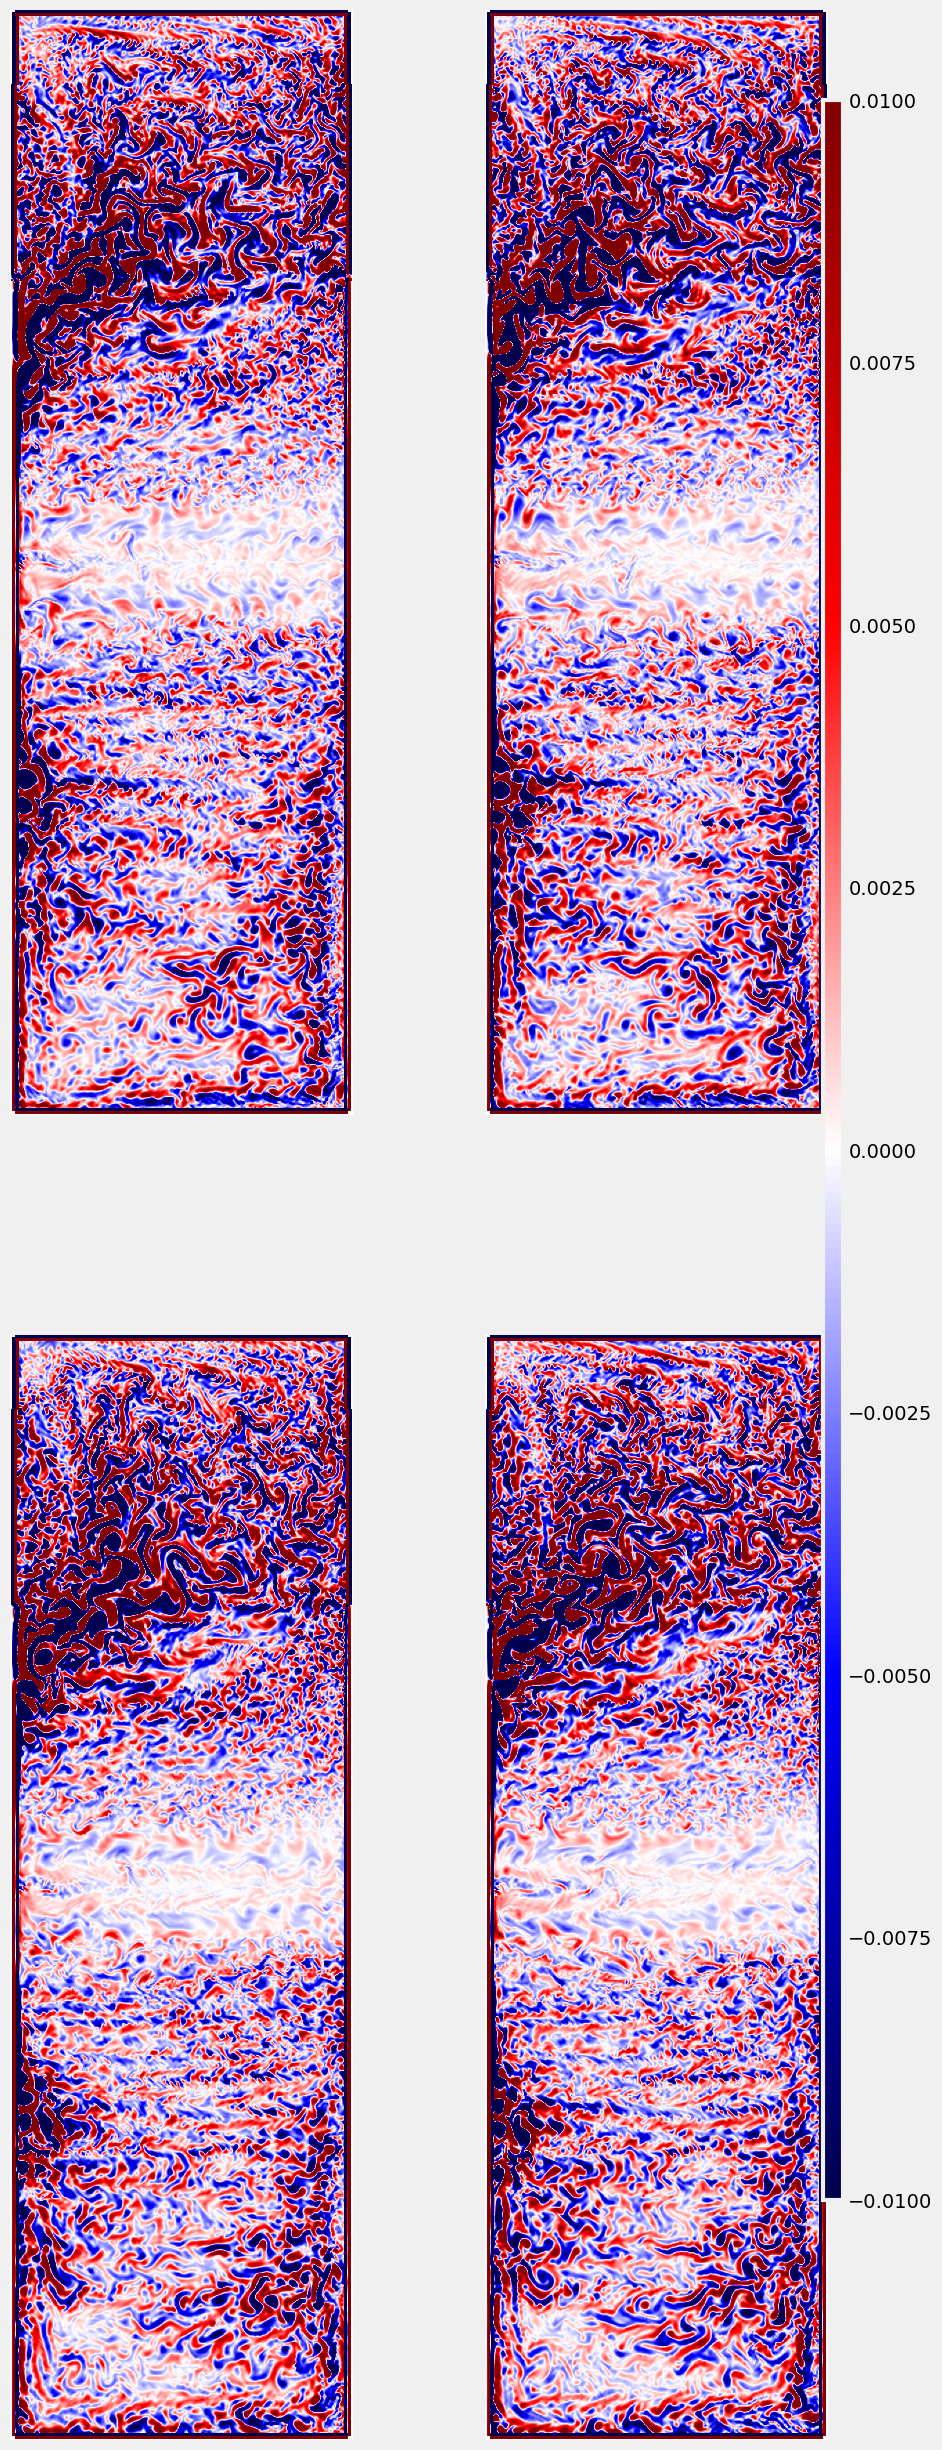

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 30))
laplacians = []

for i in range(4):
    image = test_image[i, 0].detach().cpu()
    laplacian = compute_laplacian(image)
    laplacians.append(laplacian)

    ax = axs[i // 2, i % 2]
    cax = ax.imshow(laplacian, cmap='seismic', vmax=0.01, vmin=-0.01)
    ax.axis('off')  # Hide the axis

# Create an axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position and size of colorbar

# Use the last image to set the colorbar
fig.colorbar(cax, cax=cbar_ax)

plt.show()